# ESMPY Tutorial 

based on https://github.com/nawendt/esmpy-tutorial/blob/master/esmpy_tutorial.ipynb

In [1]:
from cartopy import crs, feature
from cartopy.mpl.geoaxes import GeoAxes
import ESMF
from matplotlib import cm, rcParams
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import pyproj

#### Colorbars

In [2]:
segment1 = colors.LinearSegmentedColormap.from_list('dewpt1', [(.541,.396,.286), (.286,.255,.212), (.592,.569,.498), (1,1,1)], 30)
segment2 = colors.LinearSegmentedColormap.from_list('dewpt2', [(.894,.961,.894), (.035,.298,.035)], 10)
segment3 = colors.LinearSegmentedColormap.from_list('dewpt3', [(.38,.639,.686), (.075,.169,.165)], 5)
segment4 = colors.LinearSegmentedColormap.from_list('dewpt4', [(.404,.42,.612), (.169,.141,.404)], 5)

DEWPT_LEVELS = np.arange(-20,82,2)
DEWPT_COLORS = np.asarray([ segment1(x) for x in np.linspace(0.,1.,segment1.N) ] +
                          [ segment2(x) for x in np.linspace(0.,1.,segment2.N) ] +
                          [ segment3(x) for x in np.linspace(0.,1.,segment3.N) ] +
                          [ segment4(x) for x in np.linspace(0.,1.,segment4.N) ])

DEWPT_CMAP = colors.ListedColormap(DEWPT_COLORS)
DEWPT_CMAP.set_over((.471,.282,.439))
DEWPT_CBTIX = np.arange(-20,90,10)
DEWPT_NORM = colors.BoundaryNorm(DEWPT_LEVELS, DEWPT_CMAP.N)

#### Constants

In [3]:
EXTENT = (-121,-71,22.5,49)

def ctof(x):
    return (x * 9./5.) + 32.

#### Load Data

In [4]:
# NAM
nam = np.load('/Users/james/Downloads/nam_218_20120414_1200_006.npz', allow_pickle=True)

# RUC
ruc = np.load('/Users/james/Downloads/ruc2_130_20120414_1200_006.npz', allow_pickle=True)

# SURFACE STATIONS
sfc = np.load('/Users/james/Downloads/sfcstn_20120414_1800.npz', allow_pickle=True)

# NAM CONUS MASK
nam_mask = np.load('/Users/james/Downloads/nam_218_conus_mask.npz')

In [5]:
nam_lat = nam['lat']
nam_lon = nam['lon']
nam_p4s = nam['p4s'].tolist()

ruc_lat = ruc['lat']
ruc_lon = ruc['lon']
ruc_p4s = ruc['p4s'].tolist()

mask = nam_mask['mask']


# Dimension order for these arrays ar YX
nam_nx = nam_lat.shape[1]
nam_ny = nam_lat.shape[0]

ruc_nx = ruc_lat.shape[1]
ruc_ny = ruc_lat.shape[0]



In [6]:
ruc_crs = crs.LambertConformal(globe=crs.Globe(semimajor_axis=ruc_p4s['a'], semiminor_axis=ruc_p4s['b']),
                               central_latitude=ruc_p4s['lat_0'], central_longitude=ruc_p4s['lon_0'],
                               standard_parallels=(ruc_p4s['lat_1'], ruc_p4s['lat_2']))

nam_crs = crs.LambertConformal(globe=crs.Globe(semimajor_axis=nam_p4s['a'], semiminor_axis=nam_p4s['b']),
                               central_latitude=nam_p4s['lat_0'], central_longitude=nam_p4s['lon_0'],
                               standard_parallels=(nam_p4s['lat_1'], nam_p4s['lat_2']))

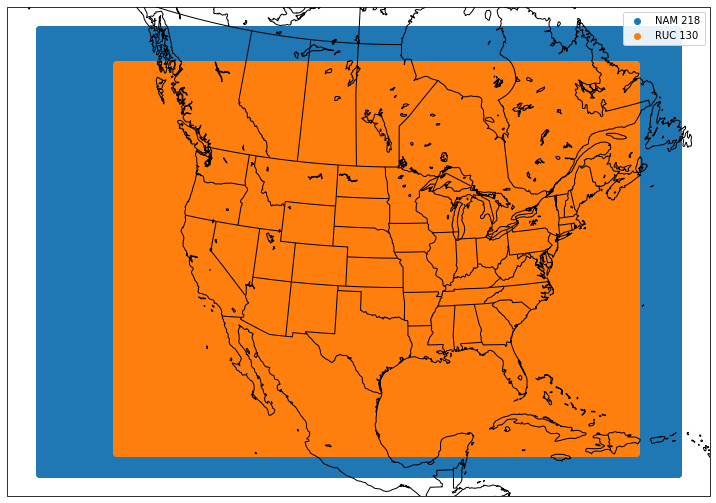

In [7]:
f1 = plt.figure(1,figsize=(16,9))
ax1 = plt.axes(projection=nam_crs)

ax1.scatter(nam_lon, nam_lat, transform=crs.PlateCarree(), label='NAM 218')
ax1.scatter(ruc_lon, ruc_lat, transform=crs.PlateCarree(), label='RUC 130')
ax1.add_feature(feature.NaturalEarthFeature(category='cultural',
                                            name='admin_1_states_provinces_lines',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax1.add_feature(feature.NaturalEarthFeature(category='physical',
                                            name='lakes',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax1.add_feature(feature.NaturalEarthFeature(category='physical',
                                            name='coastline',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax1.add_feature(feature.NaturalEarthFeature(category='cultural',
                                            name='admin_0_boundary_lines_land',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
plt.legend(loc=1, framealpha=0.9)
plt.show()


#### Interpolating From One Grid to Another
A common regridding task is to take numerical model output on one grid and interpolate it to another. For this example, we will take 2 m dewpoint temperatures from the NAM and regrid it to the RUC grid. The example data are from April 14, 2012.

#### Initialize Grids
We will need to create Grid objects for the two model grids we are using. Our sourcegrid will be from the NAM and our destination grid will be from the RUC. Our coordinates will be in the center of our grid points. As we are using latitude and longitude values, we will be using spherical coordinates. If you have coordinates that are in projection space (typically in meters) then you must use ESMF.CoordSys.CART as the coord_sys. If you are using Cartesian/projected coordinates, be sure both the source and destination grid are on the same projection. This is what ESMF assumes.

A note about efficient memory layout with ESMPy. As you will notice in a few places below, the coordinates and data being used are transposed (.T). The reason for this is that the exposed ESMF library subroutines being called are written in Fortran, not C (like numpy). Transposing the arrays just ensures that the arrays exist continguously in memory as they do natively in the ESMF Fortran subroutines. See this gist where this efficiency is shown with some performance metrics. While gaining performance is nice, it can decrease how intuitive the code is. Fortunately, I have set up a toggle below, FORTRAN_CONTIGUOUS. This way you can see how things are affected, follow the code easily, and do some of your own timings.

In [8]:
FORTRAN_CONTIGUOUS = True
if FORTRAN_CONTIGUOUS:
    nam_shape = nam_lat.T.shape
    ruc_shape = ruc_lat.T.shape
else:
    nam_shape = nam_lat.shape
    ruc_shape = ruc_lat.shape

sourcegrid = ESMF.Grid(np.array(nam_shape), staggerloc=ESMF.StaggerLoc.CENTER, coord_sys=ESMF.CoordSys.SPH_DEG)
destgrid = ESMF.Grid(np.array(ruc_shape), staggerloc=ESMF.StaggerLoc.CENTER, coord_sys=ESMF.CoordSys.SPH_DEG)


In [9]:
sourcegrid

Grid:
    type = <TypeKind.R8: 6>    areatype = <TypeKind.R8: 6>    rank = 2    num_peri_dims = 0    periodic_dim = None    pole_dim = None    coord_sys = <CoordSys.SPH_DEG: 1>    staggerloc = [True, False, False, False]    lower bounds = [array([0, 0], dtype=int32), None, None, None]    upper bounds = [array([614, 428], dtype=int32), None, None, None]    coords = [[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])], [None, None], [None, None], [None, None]]    mask = [None, None, None, None]    area = [None, None, None, None]

In [10]:
destgrid

Grid:
    type = <TypeKind.R8: 6>    areatype = <TypeKind.R8: 6>    rank = 2    num_peri_dims = 0    periodic_dim = None    pole_dim = None    coord_sys = <CoordSys.SPH_DEG: 1>    staggerloc = [True, False, False, False]    lower bounds = [array([0, 0], dtype=int32), None, None, None]    upper bounds = [array([451, 337], dtype=int32), None, None, None]    coords = [[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])], [None, None], [None, None], [None, None]]    mask = [None, None, None, None]    area = [None, None, None, None]


Right now, the Grid objects have default coordinate arrays set up based on the coord_sys and staggerloc arguments above. What they do not have are actual values (they are initialized to zero). We can add them easily by grabbing the 'pointers' to those coordinate arrays.

In [11]:
source_lon = sourcegrid.get_coords(0)
source_lat = sourcegrid.get_coords(1)

dest_lon = destgrid.get_coords(0)
dest_lat = destgrid.get_coords(1)


At this point we now have pointers to the Grid object coordinates. Be careful not to overwrite the pointer variable here (i.e., you need to treat it like an array and use the [] accessor). You need to tell it to put the values into the array that is pointed to.

In [12]:
if FORTRAN_CONTIGUOUS:
    source_lon[...] = nam_lon.T
    source_lat[...] = nam_lat.T

    dest_lon[...] = ruc_lon.T
    dest_lat[...] = ruc_lat.T
else:
    source_lon[...] = nam_lon
    source_lat[...] = nam_lat

    dest_lon[...] = ruc_lon
    dest_lat[...] = ruc_lat


In [14]:
sourcegrid, destgrid

(Grid:
     type = <TypeKind.R8: 6>    areatype = <TypeKind.R8: 6>    rank = 2    num_peri_dims = 0    periodic_dim = None    pole_dim = None    coord_sys = <CoordSys.SPH_DEG: 1>    staggerloc = [True, False, False, False]    lower bounds = [array([0, 0], dtype=int32), None, None, None]    upper bounds = [array([614, 428], dtype=int32), None, None, None]    coords = [[array([[-133.459     , -133.48966029, -133.52036817, ..., -152.74480881,
         -152.81164297, -152.8786225 ],
        [-133.35389085, -133.38447651, -133.41510967, ..., -152.59758855,
         -152.66429559, -152.73114787],
        [-133.24873431, -133.27924523, -133.30980355, ..., -152.4502235 ,
         -152.51680298, -152.58352756],
        ...,
        [ -65.34276887,  -65.31859589,  -65.29438411, ...,  -49.84322959,
          -49.78833966,  -49.73332112],
        [ -65.23414071,  -65.20988495,  -65.18559027, ...,  -49.6848239 ,
          -49.62977099,  -49.5745892 ],
        [ -65.12555139,  -65.10121294,  -65.076

In [15]:
sourcefield = ESMF.Field(sourcegrid, name='NAM 2 m DEWPOINT')

destfield = ESMF.Field(destgrid, name='RUC 2 m DEWPOINT')

In [16]:
sourcefield, destfield

(Field:
     name = 'NAM 2 m DEWPOINT'
     type = <TypeKind.R8: 6>
     rank = 2
     extra dimensions = 0
     staggerloc = <StaggerLoc.CENTER: 0>
     lower bounds = array([0, 0], dtype=int32)
     upper bounds = array([614, 428], dtype=int32)
     extra bounds = None
     data = array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])
     grid = 
 Grid:
     type = <TypeKind.R8: 6>    areatype = <TypeKind.R8: 6>    rank = 2    num_peri_dims = 0    periodic_dim = None    pole_dim = None    coord_sys = <CoordSys.SPH_DEG: 1>    staggerloc = [True, False, False, False]    lower bounds = [array([0, 0], dtype=int32), None, None, None]    upper bounds = [array([614, 428], dtype=int32), None, None, None]    coords = [[array([[-133.459     , -133.48966029, -133.52036817, ..., -152.74480881,
         -15

In [17]:
if FORTRAN_CONTIGUOUS:
    sourcefield.data[...] = nam['dpc'].T
else:
    sourcefield.data[...] = nam['dpc']

#### Regrid

In [18]:
regrid = ESMF.Regrid(sourcefield, destfield, regrid_method=ESMF.RegridMethod.BILINEAR,  
                     unmapped_action=ESMF.UnmappedAction.IGNORE)

In [20]:
destfield = regrid(sourcefield, destfield)

In [21]:
destfield

Field:
    name = 'RUC 2 m DEWPOINT'
    type = <TypeKind.R8: 6>
    rank = 2
    extra dimensions = 0
    staggerloc = <StaggerLoc.CENTER: 0>
    lower bounds = array([0, 0], dtype=int32)
    upper bounds = array([451, 337], dtype=int32)
    extra bounds = None
    data = array([[17.77705452, 17.64748959, 17.59236632, ...,  4.44310913,
         4.44310913,  4.44310913],
       [17.69319009, 17.49938638, 17.38812307, ...,  4.44310913,
         4.44310913,  4.44310913],
       [17.69318876, 17.42937214, 17.30289237, ...,  4.44310913,
         4.45727755,  4.51197935],
       ...,
       [22.06810913, 21.95269877, 21.94072901, ..., -6.6916441 ,
        -6.68410851, -6.68925193],
       [22.09276619, 22.05437374, 21.92093926, ..., -6.79505825,
        -6.70253842, -6.75043828],
       [22.19310913, 22.05860808, 21.97313379, ..., -6.76017152,
        -6.68189087, -6.68189087]])
    grid = 
Grid:
    type = <TypeKind.R8: 6>    areatype = <TypeKind.R8: 6>    rank = 2    num_peri_dims = 0    

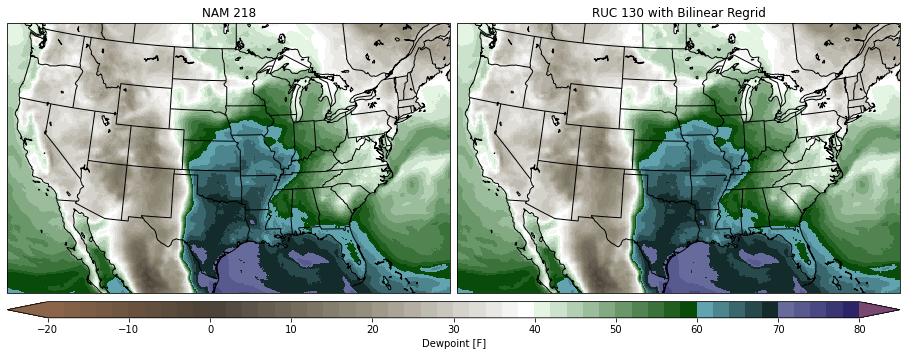

In [22]:
f2 = plt.figure(2, figsize=(16,9))
axgr = ImageGrid(f2, 111, axes_class=(GeoAxes, dict(map_projection=nam_crs)),
                 nrows_ncols=(1, 2), axes_pad=0.1, cbar_location='bottom', cbar_mode='single',
                 cbar_pad=0.025, cbar_size='3%', label_mode='')
for n, ax in enumerate(axgr):
    ax.add_feature(feature.NaturalEarthFeature(category='cultural',
                                            name='admin_1_states_provinces_lines',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
    ax.add_feature(feature.NaturalEarthFeature(category='physical',
                                                name='lakes',
                                                scale='50m',
                                                facecolor='none',
                                                edgecolor='black'))
    ax.add_feature(feature.NaturalEarthFeature(category='physical',
                                                name='coastline',
                                                scale='50m',
                                                facecolor='none',
                                                edgecolor='black'))
    ax.add_feature(feature.NaturalEarthFeature(category='cultural',
                                                name='admin_0_boundary_lines_land',
                                                scale='50m',
                                                facecolor='none',
                                                edgecolor='black'))
    if n == 0:
        ax.projection = nam_crs
    elif n == 1:
        ax.projection = ruc_crs
    ax.set_extent(EXTENT)

axgr[0].set_title('NAM 218')
pcm = axgr[0].pcolormesh(source_lon, source_lat, ctof(sourcefield.data), cmap = DEWPT_CMAP,
                         norm=DEWPT_NORM, transform=crs.PlateCarree())

axgr[1].set_title('RUC 130 with Bilinear Regrid')
axgr[1].pcolormesh(dest_lon, dest_lat, ctof(destfield.data), cmap = DEWPT_CMAP,
                   norm=DEWPT_NORM, transform=crs.PlateCarree())

cbar = plt.colorbar(pcm, cax=axgr.cbar_axes[0], orientation='horizontal', extend='both')
cbar.set_ticks(DEWPT_CBTIX)
cbar.set_label('Dewpoint [F]')
plt.show()